In [0]:
!pip freeze

In [1]:
!pip install biopython
!pip install tensorboardcolab

#!pip install h5py pyyaml
#!pip install tf_nightly

     |████████████████████████████████| 2.2MB 40.3MB/s 


In [2]:
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, LeakyReLU, Dropout, Dense, Flatten, BatchNormalization
from keras import optimizers, metrics, regularizers, initializers, applications, callbacks, models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

from Bio import SeqIO
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [3]:
tbc=TensorBoardColab(graph_path=LOG_DIR)

NameError: ignored

In [0]:
tbc.close()

In [0]:
np.random.seed(42)

In [0]:
def seq_to_one_hot(seq):
    if seq.find('N') != -1:
      return []
    
    idxs = find_all(seq, 'N') # запоминаем индексы N
    seq = seq.replace('N', 'A')
    
    seq_arr = np.array(list(seq))
    label_encoder = LabelEncoder()
    int_seq = label_encoder.fit_transform(seq_arr)
    
    int_seq = int_seq.reshape(len(int_seq), 1)
    onehot_encoder = OneHotEncoder(sparse=False)

    mtx = onehot_encoder.fit_transform(int_seq).transpose()
    # заменяем N на [0,0,0,0]
    for idx in idxs:
        mtx[:,idx] = [0,0,0,0]
    return mtx.transpose()

def target_to_one_hot(y):
    y = y.reshape(len(y), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    return onehot_encoder.fit_transform(y)
  
def one_hot_to_target(y):
    y_labels = []
    for _y in y:
        if (_y[0] == 0.) and (_y[1] == 1.):
            y_labels.append(1)
        else:
            y_labels.append(0)
    return y_labels

In [0]:
def get_seq_from_fasta(file_name):
  extr_fasta = SeqIO.parse(open(file_name),'fasta')
  train_sequence = ''
  test_sequence = ''
  for fasta in extr_fasta:
      chrom = fasta.description
      name = fasta.name
      if (name == 'chr6'):
          test_sequence = test_sequence + str(fasta.seq.upper())
      else:
          train_sequence = train_sequence + str(fasta.seq.upper())
  return train_sequence, test_sequence

def seq_to_arr(seq, window):
  arr = np.array([])
  cnt = len(seq) // window
  for i in range(0, cnt):
    arr = np.append(arr, seq[i*window : i*window + window])
  return arr

In [0]:
def find_all(seq, ch):
    return [i for i, _ch in enumerate(seq) if _ch == ch]

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))


In [0]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [11]:
extr_seq_train, extr_seq_test = get_seq_from_fasta('sample_data/loops_extr_seq.fasta')
loop_seq_train, loop_seq_test = get_seq_from_fasta('sample_data/loops_seq.fasta')
inner_seq_train, inner_seq_test = get_seq_from_fasta('sample_data/inner_seq.fasta')
outer_seq_train, outer_seq_test = get_seq_from_fasta('sample_data/outer_seq.fasta')

#print (len(extr_seq), len(loop_seq), len(inner_seq), len(outer_seq))
#print ((len(inner_seq)+len(outer_seq))*1. / (len(extr_seq)+len(loop_seq)))

#extr_seq = extr_seq[:len(extr_seq)//2]
#loop_seq = loop_seq[:len(loop_seq)//2]

inner_seq_train = inner_seq_train[:len(extr_seq_train)]#[:len(inner_seq)//2]
outer_seq_train = outer_seq_train[:len(loop_seq_train)]#[:len(outer_seq)//2]
inner_seq_test = inner_seq_test[:len(extr_seq_test)]
outer_seq_test = outer_seq_test[:len(loop_seq_test)]
print(len(extr_seq_train), len(loop_seq_train), len(inner_seq_train), len(outer_seq_train))
print(len(extr_seq_test), len(loop_seq_test), len(inner_seq_test), len(outer_seq_test))

(106000, 978000, 106000, 978000)
(4000, 92000, 4000, 92000)


In [12]:
window = 2000
# массивы последовательностей длиной по 2000bp каждая
extr_arr_train = seq_to_arr(extr_seq_train, window)
loop_arr_train = seq_to_arr(loop_seq_train, window)
inner_arr_train = seq_to_arr(inner_seq_train, window)
outer_arr_train = seq_to_arr(outer_seq_train, window)

# делаем one-hot
extr_mtx_train = np.array([seq_to_one_hot(s) for s in extr_arr_train if (s.find('N') == -1) and (s.find('n') == -1)])
loop_mtx_train = np.array([seq_to_one_hot(s) for s in loop_arr_train if (s.find('N') == -1) and (s.find('n') == -1)])
inner_mtx_train = np.array([seq_to_one_hot(s) for s in inner_arr_train if (s.find('N') == -1) and (s.find('n') == -1)])
outer_mtx_train = np.array([seq_to_one_hot(s) for s in outer_arr_train if (s.find('N') == -1) and (s.find('n') == -1)])

np.shape(extr_mtx_train), np.shape(loop_mtx_train), np.shape(inner_mtx_train), np.shape(outer_mtx_train)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


((53, 2000, 4), (487, 2000, 4), (53, 2000, 4), (484, 2000, 4))

In [13]:
# массивы последовательностей длиной по 2000bp каждая
extr_arr_test = seq_to_arr(extr_seq_test, window)
loop_arr_test = seq_to_arr(loop_seq_test, window)
inner_arr_test = seq_to_arr(inner_seq_test, window)
outer_arr_test = seq_to_arr(outer_seq_test, window)

# делаем one-hot
extr_mtx_test = np.array([seq_to_one_hot(s) for s in extr_arr_test if (s.find('N') == -1) and (s.find('n') == -1)])
loop_mtx_test = np.array([seq_to_one_hot(s) for s in loop_arr_test if (s.find('N') == -1) and (s.find('n') == -1)])
inner_mtx_test = np.array([seq_to_one_hot(s) for s in inner_arr_test if (s.find('N') == -1) and (s.find('n') == -1)])
outer_mtx_test = np.array([seq_to_one_hot(s) for s in outer_arr_test if (s.find('N') == -1) and (s.find('n') == -1)])

np.shape(extr_mtx_test), np.shape(loop_mtx_test), np.shape(inner_mtx_test), np.shape(outer_mtx_test)

((2, 2000, 4), (45, 2000, 4), (2, 2000, 4), (44, 2000, 4))

In [14]:
x_train = np.vstack((extr_mtx_train, loop_mtx_train, inner_mtx_train, outer_mtx_train)) # num of seqs * 4 * window
_y_train = [1]*len(extr_mtx_train) + [1]*len(loop_mtx_train) + [0]*len(inner_mtx_train) + [0]*len(outer_mtx_train)
y_train = np.vstack(target_to_one_hot(np.array(_y_train)))
#print (x.shape, y.shape)
x_test = np.vstack((extr_mtx_test, loop_mtx_test, inner_mtx_test, outer_mtx_test)) # num of seqs * 4 * window
_y_test = [1]*len(extr_mtx_test) + [1]*len(loop_mtx_test) + [0]*len(inner_mtx_test) + [0]*len(outer_mtx_test)
y_test = np.vstack(target_to_one_hot(np.array(_y_test)))

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((1077, 2000, 4), (1077, 2), (93, 2000, 4), (93, 2))


In [15]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(_y_train),
                                                 _y_train)
class_weights

array([1.0027933 , 0.99722222])

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(_y_test),
                                                 _y_test)
class_weights

array([1.01086957, 0.9893617 ])

In [0]:
tf.reset_default_graph()
K.clear_session()

In [0]:
import os
import requests
import shutil
import subprocess
import tensorflow as tf

__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary
  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`
  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error
  """
  #install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = False #len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = False #len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}, log_dir={}".format(is_tensorboard_running, is_ngrok_running, log_dir))

  if not is_tensorboard_running:
    print log_dir
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6666 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6666 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(10)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url


In [18]:
import time
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, 'new_logs')
LOG_DIR #os.chdir('/content')

u'/content/new_logs'

In [0]:
!cp /tmp/new_logs/events.out.tfevents.1558070717.ab44419f904f /content/new_logs/2x128_2x64_d256_d128_1e-4__1558070708

In [0]:
!cp -r /content/new_logs/2x128_2x64_d256_d128_simple_1e-4__1558083034/ /tmp/new_logs/2x128_2x64_d256_d128_simple_1e-4__1558083034/

In [72]:
!pip install ngrok

  Stored in directory: /root/.cache/pip/wheels/7c/e5/bb/0aba6d734b1363ac037c3806ba9c5af55cc0f5f6d711153813
Successfully built ngrok


In [83]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/usr/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python2.7/json/decoder.py", line 364, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python2.7/json/decoder.py", line 382, in raw_decode
    raise ValueError("No JSON object could be decoded")
ValueError: No JSON object could be decoded


In [0]:
tf.reset_default_graph()
K.clear_session()

In [0]:
# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
!python -m visdom.server

launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

In [90]:
LOG_DIR = '/content/new_logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
updated 1 package in 1.44s
your url is: https://helpless-firefox-22.localtunnel.me


In [91]:
LOG = os.path.join('/content/new_logs', '2x128_2x64_d256_d128_lrelu_1e-4__{}'.format(int(time.time())))
tf.reset_default_graph()
K.clear_session()

num_classes = 2
batch_size=64
num_train_samples= x_train.shape[0] # 374
kernal_init = initializers.VarianceScaling(scale=2.0, mode='fan_avg', distribution='normal', seed=42)
kernel_reg = regularizers.l2(0.01)

base_model = Sequential()
base_model.add(Conv2D(128, (9, 4), padding='valid', kernel_initializer = kernal_init,
kernel_regularizer=kernel_reg, input_shape=(window, 4, 1), activity_regularizer=kernel_reg)) 
base_model.add(Activation('relu'))
base_model.add(Conv2D(128, (9, 1), padding='valid', kernel_initializer = kernal_init,
kernel_regularizer=kernel_reg, activity_regularizer=kernel_reg)) 
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 1), strides=2))

base_model.add(Conv2D(128, (7, 1), padding='valid', kernel_initializer = kernal_init,
kernel_regularizer=kernel_reg, activity_regularizer=kernel_reg)) 
base_model.add(Activation('relu'))
base_model.add(Conv2D(128, (7, 1), padding='valid', kernel_initializer = kernal_init,
kernel_regularizer=kernel_reg, activity_regularizer=kernel_reg)) 
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 1), strides=2))

base_model.add(Flatten())
base_model.add(Dense(256, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(128, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(num_classes))
base_model.add(Activation('softmax'))

opt = optimizers.adam(lr=1e-4) #1e-4, decay=1e-6)
base_model.compile(optimizer=opt, loss='binary_crossentropy',
metrics=[f1, keras.metrics.binary_accuracy, keras.metrics.mean_absolute_error])
tbCallBack = callbacks.TensorBoard(log_dir=LOG, histogram_freq=1,
write_graph=True,
write_grads=True,
batch_size=batch_size,
write_images=True)

history = base_model.fit(x_train.reshape((x_train.shape[0], window, 4,1)), y_train, 
validation_data=(x_test.reshape((x_test.shape[0], window, 4,1)), y_test), batch_size=batch_size,
epochs=80, callbacks=[tbCallBack], verbose=1)

Train on 1077 samples, validate on 93 samples
Epoch 1/80
1077/1077 [==============================] - 3s 3ms/step - loss: 778.0498 - f1: 0.4514 - binary_accuracy: 0.4884 - mean_absolute_error: 0.5019 - val_loss: 522.7433 - val_f1: 0.2914 - val_binary_accuracy: 0.5054 - val_mean_absolute_error: 0.4999
Epoch 2/80
1077/1077 [==============================] - 1s 1ms/step - loss: 555.7369 - f1: 0.5192 - binary_accuracy: 0.5274 - mean_absolute_error: 0.4980 - val_loss: 414.1374 - val_f1: 0.3370 - val_binary_accuracy: 0.4839 - val_mean_absolute_error: 0.5000
Epoch 3/80
1077/1077 [==============================] - 1s 1ms/step - loss: 448.0145 - f1: 0.5160 - binary_accuracy: 0.5237 - mean_absolute_error: 0.4976 - val_loss: 341.1915 - val_f1: 0.2914 - val_binary_accuracy: 0.5054 - val_mean_absolute_error: 0.4999
Epoch 4/80
1077/1077 [==============================] - 2s 1ms/step - loss: 371.9225 - f1: 0.5175 - binary_accuracy: 0.5246 - mean_absolute_error: 0.4979 - val_loss: 286.4415 - val_f1: 0

In [55]:
y_pred = base_model.predict(x_test.reshape(x_test.shape[0], window, 4, 1))
metrics.roc_auc_score(one_hot_to_target(y_test), 
                                     (np.argmax(y_pred,axis=1)))

0.6780758556891767

In [151]:
# train
y_pred = base_model.predict(x_train.reshape(x_train.shape[0], window, 4, 1))
metrics.roc_auc_score(one_hot_to_target(y_train), 
                                     (np.argmax(y_pred,axis=1)))

1.0

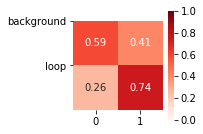

In [57]:
conf_mtrx = metrics.confusion_matrix(one_hot_to_target(y_test), 
                                     (np.argmax(y_pred,axis=1)))
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T

plt.figure(figsize=[2,2])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True, annot=True)
plt.yticks(np.arange(2), ['background', 'loop'])
plt.yticks(rotation=0) 
plt.show()

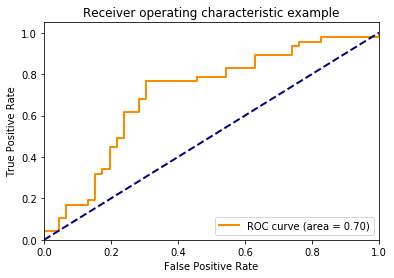

In [393]:
from sklearn.metrics import roc_curve, auc
lw = 2
y_pred_proba = base_model.predict_proba(x_test.reshape(x_test.shape[0], window, 4, 1)) #search_cv.best_estimator_.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(one_hot_to_target(y_test), y_pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


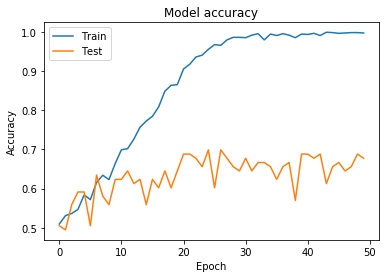

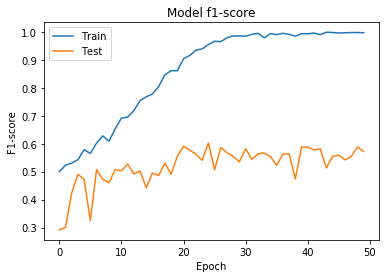

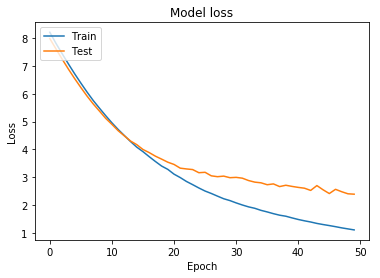

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation f1 values
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [29]:
layer_outputs = [layer.output for layer in base_model.layers[:1]] 
layer_outputs

[<tf.Tensor 'conv2d_5/BiasAdd:0' shape=(?, 1992, 1, 128) dtype=float32>]

In [30]:
activation_model = models.Model(inputs=base_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
x = x_train[1, :, :]
activations = activation_model.predict(x.reshape(1, window,4,1)) # Returns a list of five Numpy arrays: one array per layer activation
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1992, 1, 128)


In [130]:
filters.shape

(9, 4, 1, 128)

In [135]:
activations.shape

(1, 1992, 1, 128)

In [0]:
nuc_cnts = [0]*4 # background
for i in range(0,n_samples):
    x = x_train[i, :, :]
    activations = activation_model.predict(x.reshape(1, window,4,1)) # one array per layer activation
    first_layer_activation = activations[0]
    mean = np.mean(first_layer_activation[:,:,f_i].T[0])
    activ_seq_ind = np.where(first_layer_activation[:, :, f_i].T > mean)[1] 
    for i in activ_seq_ind:
        seq = x[i:i+9, :]
        nuc_cnts = np.add(nuc_cnts, [np.sum(seq[:, 0]), np.sum(seq[:, 1]), np.sum(seq[:, 2]), np.sum(seq[:, 3])])
nuc_cnts = nuc_cnts / (n_samples*len(activ_seq_ind)*9)

In [0]:
n_samples = 100
filters_max = [0]*128
filter_thres = [0]*128
for f_i in range(0,128):
    for i in range(0,n_samples):
        x = x_train[i*10, :, :]
        activations = activation_model.predict(x.reshape(1, window,4,1)) # one array per layer activation
        first_layer_activation = activations[0]
        filter_thres[f_i] = filter_thres[f_i] + np.sum(first_layer_activation[:,:,f_i])
        for a in first_layer_activation[:,:,f_i]:
            if a > filters_max[f_i]:
                filters_max[f_i] = a
filter_thres = np.divide(filter_thres, (first_layer_activation.shape[0]*n_samples))

In [45]:
filters_max[0]

array([0.42187592], dtype=float32)

In [46]:
filter_thres[0]

0.12089999585745326

In [0]:
np.mean(first_layer_activation[:,:,0]), np.max(first_layer_activation[:,:,0])

(0.1183683, 0.37974006)

In [0]:
n_samples = 100
with open('/content/sample_data/filters.txt', 'w') as out:
    for f_i in range(0,128):
        pwms = np.array([[0]*4]*9)
        for i in range(0,n_samples):
            x = x_train[i, :, :]
            activations = activation_model.predict(x.reshape(1, window,4,1)) # one array per layer activation
            first_layer_activation = activations[0]
            mean = np.max(first_layer_activation[:,:,f_i].T[0]) / 2
            activ_seq_ind = np.where(first_layer_activation[:, :, f_i].T > mean)[1]  
        for j in activ_seq_ind:
            seq = x[j:j+9, :]
            pwms = np.add(pwms, seq)
        pwms = pwms / (len(activ_seq_ind)*n_samples)

        out.write('>Filter ' + str(f_i) + '\n')
        #out.write('Pos\tA\tC\tG\tT\n')
        for j in range(0, 9):
            s = str((pwms[j,0])) + '\t' + \
                str((pwms[j,1])) + '\t' + \
                str((pwms[j,2])) + '\t' + \
                str((pwms[j,3])) + '\n'
            out.write(s)
        out.write('\n')

In [113]:
pwms / 989

array([[0.36501517, 0.0859454 , 0.08291203, 0.4661274 ],
       [0.31142568, 0.08291203, 0.13953488, 0.4661274 ],
       [0.53488372, 0.11223458, 0.17492417, 0.17795753],
       [0.54196158, 0.04145602, 0.13043478, 0.28614762],
       [0.38624874, 0.06167846, 0.13043478, 0.42163802],
       [0.38523761, 0.11223458, 0.10717897, 0.39534884],
       [0.21233569, 0.07178969, 0.08998989, 0.62588473],
       [0.34479272, 0.10313448, 0.15065723, 0.40141557],
       [0.49949444, 0.11729019, 0.11729019, 0.26592518]])

In [54]:
mean = np.mean(first_layer_activation[:,:,0].T[0])
mean

0.110091105

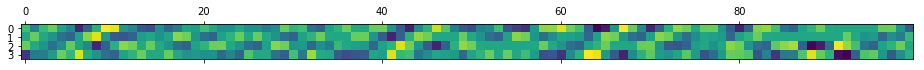

In [75]:
plt.matshow(first_layer_activation[:100, :, 0].T) #, cmap='viridis')


In [0]:
layer_weights = np.array(model3.layers[0].get_weights())


In [94]:
len(layer_weights[0]), len(layer_weights[1])

(9, 128)

In [0]:
filters = base_model.layers[0].get_weights()

In [0]:
filters = filters[0]

In [0]:
filters_cp = filters

In [62]:
np.shape(filters)

(9, 4, 1, 128)

In [0]:
norm_filters = []
for i in range(0, 128):
    norm_filter = []
    for j in range(0, 9):
        f = filters[j,:,:,i]
        #norm_f = (f - f_min) / (f_max - f_min)
        norm_f = (f-np.min(f)) / (np.sum(f-np.min(f)))
        norm_filter.append(norm_f)
    norm_filters.append(norm_filter)

In [366]:
np.shape(norm_filters)

(128, 9, 4, 1)

In [368]:
norm_filters[0][0]

array([[0.        ],
       [0.42524558],
       [0.42388323],
       [0.15087114]], dtype=float32)

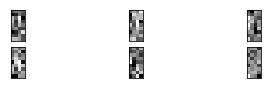

In [274]:
from matplotlib import pyplot

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    #for j in range(3):
    # specify subplot and turn of axis
    ax = pyplot.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

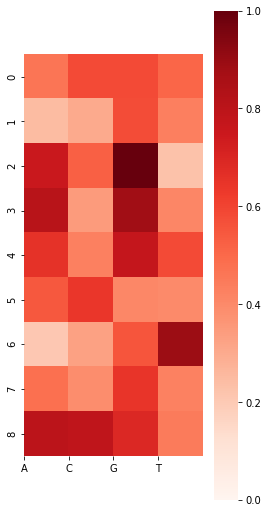

In [285]:
f = norm_filters[:, :, :, 0]
plt.figure(figsize=[4,9])
sns.heatmap(f[:, :, 0], cmap='Reds', vmax=1, vmin=0, square=True)
plt.xticks(np.arange(4), ['A', 'C', 'G', 'T']) 
plt.xticks(rotation=0) 

In [0]:
with open('/content/sample_data/filters.txt', 'w') as out:
    for i in range(0, 128):
        f = norm_filters[i]
        out.write('Filter ' + str(i) + '\n')
        out.write('Pos\tA\tC\tG\tT\n')
        for j in range(0, 9):
            s = str(j) + '\t' + str(f[j][0][0]) + '\t' + str(f[j][1][0]) + '\t' + \
            str(f[j][2][0]) + '\t' + str(f[j][3][0]) + '\n'
            out.write(s)
        out.write('\n')